# PMLBmini experiments

This notebook runs the PMLBmini experiments, and compares RANDOM FEATURE BOOSTING and END2END to the saved PMLBmini models

NOTE that we assume tabmini is installed in the cwd https://github.com/RicardoKnauer/TabMini 

Should take no more than 30 minutes to run this notebook, ie run all models and datasets sequentially on a single CPU core

In [1]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import os
import pickle
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, tensor
import pandas as pd
import tabmini
import aeon
from aeon.visualisation import plot_critical_difference, plot_significance
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from models.gridsearch_wrapper import SKLearnWrapper
from models.random_feature_representation_boosting import GradientRFRBoostClassifier
from models.end2end import End2EndMLPResNet
from PMLBmini import test_on_PMLBmini

In [2]:
##############################################
#####      Equal/Random Guessing        ######
##############################################


class EqualGuessing(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        return self

    def predict_proba(self, X):
        """Guess probabilty 0.5 for each class"""
        # Guess [0.5, 0.5]
        return np.ones((X.shape[0], 2)) * 0.5

    def decision_function(self, X):
        # Get the probabilities from predict_proba
        proba = self.predict_proba(X)
        # Calculate the log of ratios for binary classification
        decision = np.log((proba[:, 1] + 1e-10) / (proba[:, 0] + 1e-10))
        return decision
    


In [3]:
save_dir = "/home/nikita/Code/random-feature-boosting/results/PMLBmini/"

train_guessing_and_xgboost, test_guessing_and_xgboost = test_on_PMLBmini(
    EqualGuessing(),
    'EqualGuessing',
    [i for i in range(44)],
    save_dir, 
    other_saved_methods={"XGBoost"},
    )

Dataset found, loading
Evaluating EqualGuessing against {'XGBoost'}...
Comparing EqualGuessing on 0: analcatdata_aids
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is in methods: XGBoost
estimated name is not in methods: CatBoost
Testing xgboost with 1 job(s)
Testing EqualGuessing
Comparing EqualGuessing on 1: analcatdata_asbestos
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is in methods: XGBoost
estimated name is not in methods: CatBoost
Testing xgboost with 1 job(s)
Testing EqualGuessing
Comparing EqualGuessing on 2: analcatdata_bankruptcy
estimated name is not in methods: AutoGluon
estimated name is not in met

In [ ]:
# !python PMLBmini.py \
#     --models E2E_MLP_ResNet \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/results/PMLBmini/ \
#     --seed 42

In [7]:
for i in range(44):
    !python PMLBmini.py \
        --models "Logistic(ours)" \
        --dataset_indices {i} \
        --save_dir /home/nikita/Code/random-feature-boosting/results/PMLBmini/ \
        --seed 42

Dataset found, loading
Evaluating Logistic(ours) against {}...
Comparing Logistic(ours) on 0: analcatdata_aids
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing Logistic(ours)
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END hidden_dim=32, in_dim=4, l2_cls=100, modelClass=<class 'models.random_feature_representation_boosting.GradientRFRBoostClassifier'>, n_classes=2, n_layers=0, seed=42, upscale_type=identity;, score=0.417 total time=   0.6s
[CV 2/5] END hidden_dim=32, in_dim=4, l2_cls=100, modelClass=<class 'models.random_feature_representation_boosting.GradientRFRBoostClassifier'>, n_classes=2, n_layers=0, seed=42, upscale_type=identity;, score=0.667 total time=   0.0s
[CV 3/5] END hidden_dim=32, in_di

In [ ]:
# !python PMLBmini.py \
#     --models GRFRBoost_featSWIM_upiid_linesearchTrue_freezeFalse \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/results/PMLBmini/ \
#     --seed 42

In [17]:
# Load the CSV and set the index
saved_results = pd.read_csv('https://raw.githubusercontent.com/RicardoKnauer/TabMini/master/plotting/results/test_scores_wide_3600.csv', delimiter=";", index_col=0)
saved_results.index.name = None
saved_results

,AutoPrognosis,AutoGluon,TabPFN,Logistic regression,HyperFast
parity5,0.27,1.00,0.02,0.17,0.02
analcatdata_fraud,0.86,0.80,0.79,0.77,0.73
analcatdata_aids,0.73,0.77,0.63,0.61,0.53
analcatdata_bankruptcy,0.98,0.98,0.96,0.97,0.88
analcatdata_japansolvent,0.85,0.88,0.91,0.85,0.91
labor,0.88,0.94,0.99,0.97,0.98
analcatdata_asbestos,0.87,0.84,0.85,0.86,0.87
lupus,0.84,0.79,0.82,0.85,0.79
postoperative_patient_data,0.49,0.55,0.44,0.38,0.34
analcatdata_cyyoung9302,0.89,0.85,0.87,0.87,0.84


In [85]:
# join all the models
import itertools
model_names = ["E2E_MLP_ResNet", "RFNN", "RFNN_iid", "Logistic(ours)"]
for feat, up, linesearch, freeze in itertools.product(["SWIM", "iid"], ["identity", "SWIM", "iid"], [True, False], [True, False]):
    name = f"GRFRBoost_feat{feat}_up{up}_linesearch{linesearch}_freeze{freeze}"
    model_names.append(name)

In [86]:
# join all the models
import itertools
model_names = ["E2E_MLP_ResNet", "RFNN"]
for feat, up, linesearch, freeze in itertools.product(["SWIM"], ["SWIM"], [False], [False]):
    name = f"GRFRBoost_feat{feat}_up{up}_linesearch{linesearch}_freeze{freeze}"
    model_names.append(name)

In [88]:
combined_results = saved_results.copy()
for model_name in model_names:
    results_one_model = [pd.read_csv(f"{save_dir}/{model_name}/test_{i}.csv", index_col=0)
                         for i in range(44)]
    df_one_model = pd.concat(results_one_model, axis=0)
    combined_results = combined_results.join(df_one_model)
combined_results = combined_results.round(2)
combined_results

,AutoPrognosis,AutoGluon,TabPFN,Logistic regression,HyperFast,E2E_MLP_ResNet,RFNN,GRFRBoost_featSWIM_upSWIM_linesearchFalse_freezeFalse
parity5,0.27,1.00,0.02,0.17,0.02,0.57,0.17,0.34
analcatdata_fraud,0.86,0.80,0.79,0.77,0.73,0.31,0.74,0.68
analcatdata_aids,0.73,0.77,0.63,0.61,0.53,0.53,0.73,0.71
analcatdata_bankruptcy,0.98,0.98,0.96,0.97,0.88,0.81,0.94,0.93
analcatdata_japansolvent,0.85,0.88,0.91,0.85,0.91,0.69,0.88,0.90
labor,0.88,0.94,0.99,0.97,0.98,0.54,0.92,0.94
analcatdata_asbestos,0.87,0.84,0.85,0.86,0.87,0.82,0.79,0.87
lupus,0.84,0.79,0.82,0.85,0.79,0.81,0.85,0.81
postoperative_patient_data,0.49,0.55,0.44,0.38,0.34,0.44,0.39,0.37
analcatdata_cyyoung9302,0.89,0.85,0.87,0.87,0.84,0.82,0.81,0.87


In [216]:
combined_results.query("TabPFN > GRFRBoost_featSWIM_upSWIM_linesearchFalse_freezeFalse")

,GRFRBoost_featSWIM_upSWIM_linesearchFalse_freezeFalse,RFNN,E2E_MLP_ResNet,HyperFast,Logistic regression,TabPFN,AutoGluon,AutoPrognosis
analcatdata_fraud,0.68,0.74,0.31,0.73,0.77,0.79,0.80,0.86
analcatdata_bankruptcy,0.93,0.94,0.81,0.88,0.97,0.96,0.98,0.98
analcatdata_japansolvent,0.90,0.88,0.69,0.91,0.85,0.91,0.88,0.85
labor,0.94,0.92,0.54,0.98,0.97,0.99,0.94,0.88
lupus,0.81,0.85,0.81,0.79,0.85,0.82,0.79,0.84
postoperative_patient_data,0.37,0.39,0.44,0.34,0.38,0.44,0.55,0.49
analcatdata_cyyoung8092,0.82,0.77,0.69,0.84,0.79,0.85,0.90,0.73
analcatdata_creditscore,0.95,0.95,0.91,0.87,0.94,1.00,0.99,1.00
appendicitis,0.80,0.77,0.75,0.87,0.84,0.82,0.84,0.78
glass2,0.77,0.79,0.69,0.79,0.72,0.89,0.91,0.89


/tmp/ipykernel_77291/3040158871.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


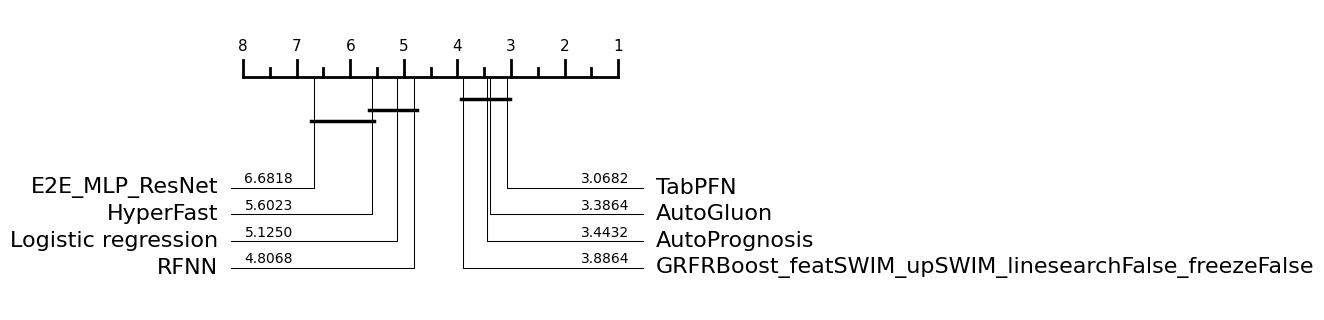

In [215]:
import matplotlib.pyplot as plt

# Generate the plot
plot = plot_critical_difference(combined_results.values,
                                combined_results.columns.tolist(), 
                                alpha=0.10, 
                                lower_better=False)

# Retrieve the figure and axes from the plot
fig = plot[0].figure
ax = plot[0]

# Adjust figure size
fig.set_size_inches(6, 3)

# Adjust layout
fig.tight_layout()

# Save the figures
fig.savefig(f"{save_dir}PMLBmini_critical_difference.eps", bbox_inches='tight')
fig.savefig(f"{save_dir}PMLBmini_critical_difference.png", bbox_inches='tight')

In [81]:
import pandas as pd
import numpy as np

def create_latex_table(df):
    table = """
\\begin{table}[t]
\\caption{Test accuracies on the concentric circles task.}
\\label{tab:concentric-circles}
\\vskip 0.15in
\\begin{center}
\\begin{small}
\\begin{sc}
\\begin{tabular}{lcc}
\\toprule
Model & Mean Acc & Std Dev \\\\
\\midrule
"""
    for model_name in df.columns:
        accs = df[model_name]
        mean_acc = np.mean(accs)
        std_acc = np.std(accs)
        table += f"{model_name} & {mean_acc:.4f} & {std_acc:.4f} \\\\\n"
    
    table += """
\\bottomrule
\\end{tabular}
\\end{sc}
\\end{small}
\\end{center}
\\vskip -0.1in
\\end{table}
"""
    return table

# Example usage
# Assuming `results_df` is your pandas DataFrame
latex_table = create_latex_table(combined_results)
print(latex_table)


\begin{table}[t]
\caption{Test accuracies on the concentric circles task.}
\label{tab:concentric-circles}
\vskip 0.15in
\begin{center}
\begin{small}
\begin{sc}
\begin{tabular}{lcc}
\toprule
Model & Mean Acc & Std Dev \\
\midrule
AutoPrognosis & 0.8539 & 0.1445 \\
AutoGluon & 0.8791 & 0.1068 \\
TabPFN & 0.8495 & 0.1724 \\
Logistic regression & 0.8193 & 0.1588 \\
HyperFast & 0.8166 & 0.1785 \\
E2E_MLP_ResNet & 0.7923 & 0.1585 \\
RFNN & 0.8309 & 0.1524 \\
GRFRBoost_featSWIM_upSWIM_linesearchTrue_freezeTrue & 0.8445 & 0.1493 \\

\bottomrule
\end{tabular}
\end{sc}
\end{small}
\end{center}
\vskip -0.1in
\end{table}



# experiment on single

In [32]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import os
import pickle
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, tensor
import pandas as pd
import tabmini
import aeon
from aeon.visualisation import plot_critical_difference, plot_significance
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from models.base import LogisticRegression
from models.gridsearch_wrapper import SKLearnWrapper
from models.random_feature_representation_boosting import GradientRFRBoostClassifier
from models.end2end import End2EndMLPResNet

class Config:
    save_dir = Path.cwd() / "results" / "PMLBmini"

In [33]:
# experiment on a single dataset

#download dataset, cache it
dataset_save_path = Config.save_dir / 'PMLBmini_dataset.pkl'
if not os.path.exists(dataset_save_path):
    print("Dataset not found, downloading")
    dataset = tabmini.load_dataset(reduced=False)
    os.makedirs(Config.save_dir, exist_ok=True)
    with open(dataset_save_path, 'wb') as f:
        pickle.dump(dataset, f)
else:
    print("Dataset found, loading")
    with open(dataset_save_path, 'rb') as f:
        dataset = pickle.load(f)

Dataset found, loading


In [269]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 10: parity5
X, y = dataset["irish"]
# X, y = dataset["parity5"]
# scaler = MinMaxScaler()
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X).float()
y = torch.tensor(y.values)[..., None].float()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [270]:
X.shape

torch.Size([500, 5])

In [275]:
# model = LogisticRegression(
#     n_classes=2,
#     l2_lambda=0.0001,
#     max_iter = 300,
# )
np.random.seed(42)
torch.manual_seed(42)

model = GradientRFRBoostClassifier(
    in_dim=X.shape[1],
    n_classes=2,
    l2_cls=0.01,
    l2_ghat=0.01,
    n_layers=3,
    randfeat_xt_dim=512,
    randfeat_x0_dim=512,
    hidden_dim=512,
    upscale_type="SWIM",
    feature_type="SWIM",
    use_batchnorm=False,
    boost_lr=0.1,
    activation="tanh",
    do_linesearch=False,
    freeze_top_at_t=2,
)
model.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score

logits = model(X_test)
print("logits", logits)
probs = nn.functional.sigmoid(logits)
print("out and y", torch.cat([logits, y_test], dim=1))
print("binary class pred and y", torch.cat([probs > 0.5, y_test], dim=1))
auc = roc_auc_score(y_test.numpy(), probs.detach().numpy())
print("test AUC:", auc)

#train
model.eval()
logits = model(X_train)
probs = nn.functional.sigmoid(logits)
auc = roc_auc_score(y_train.numpy(), probs.detach().numpy())
print("train AUC:", auc)

logits tensor([[-0.74144411087036132812],
        [-5.02471256256103515625],
        [-4.10620212554931640625],
        [ 2.31260204315185546875],
        [ 3.46384906768798828125],
        [-4.56789207458496093750],
        [-2.93006420135498046875],
        [ 2.58553862571716308594],
        [ 1.42366456985473632812],
        [ 1.73735380172729492188],
        [ 2.81844902038574218750],
        [ 3.09712481498718261719],
        [-2.74952411651611328125],
        [-3.89432430267333984375],
        [-3.73368358612060546875],
        [ 3.20897984504699707031],
        [-0.08921241760253906250],
        [-2.02951431274414062500],
        [-3.57656383514404296875],
        [-3.41771030426025390625],
        [-2.37996768951416015625],
        [ 3.70155334472656250000],
        [ 0.29131460189819335938],
        [-4.41245937347412109375],
        [-4.29550075531005859375],
        [-2.35178947448730468750],
        [-1.72292995452880859375],
        [-3.39835643768310546875],
        [ 2.9